In [1]:
import numpy as np

In [2]:
#generate points in a portion of a unit sphere

chambers = [5.0-2*0.03, 5.0-0.03, 5.0+0.03, 5.0+2*0.03, 5.17-2*0.03,5.17-0.03, 5.17+0.03, 5.17+2*0.03, 7.5-0.03,7.5,7.5+0.03, 
              7.817-0.03,7.817,7.917+0.03, 10.0-0.03,10.0,10.0+0.03, 10.317-0.03,10.317,10.317+0.03]

def gen_points(num_points=2):
  points = np.empty(shape=(0,3))
  inters = np.empty(shape=(0,20,4))
  targets = np.empty(shape=(3))
  eta = 0.4
  theta = 0.5*np.pi-2*np.arctan(np.exp(-eta))
  cost = np.cos(theta)

  eta0 = np.random.uniform(-0.3,0.3)
  theta0 = 0.5*np.pi-2*np.arctan(np.exp(-eta0))
  ct0 = np.cos(theta0)
  st0 = np.sin(theta0)
  R = np.array([[1,   0,   0], 
                [0, ct0, -st0], 
                [0, st0,  ct0]])
  
  z0 = np.random.uniform(0.0, 0.1)
  


  #phi_min = np.random.uniform(0,np.pi/4.)
  phi_min = 0.0
  phi_max = phi_min + np.pi/2.
  #d_phi = phi_max/num_points
  #phi = np.random.uniform(0,2*np.pi)
    
  for i in range(num_points):

    z = np.random.uniform(cost,1.)
    #phi = np.random.uniform(phi_min, phi_max)

    if (i == 0):
      phi = phi_min
    elif (i == (num_points-1)):
      phi = phi_max
    else:
      phi = np.random.uniform(phi_min, phi_max)

    #print(phi)
    
    v = np.array([np.sqrt(1-z*z)*np.cos(phi),np.sqrt(1-z*z)*np.sin(phi),z]) 
    v = np.dot(R,v)

    cth = v[2]
    sth = np.sqrt(1-cth*cth)
    sph = v[1]/(sth)
    cph = v[0]/(sth) 
    rst = 1/cth
    
    inters_tmp = np.empty(shape=(0,4))
    for index,j in enumerate(chambers):
      xp = (j-z0)*rst*sth*cph
      yp = (j-z0)*rst*sth*sph
      zp = j*cth*rst
      if (j >= z0):
        u = np.array([xp,yp,zp,index])
      else:
        u = np.array([99999.,99999.,99999.,index])

      u = np.reshape(u, (1,4))
      inters_tmp = np.concatenate((inters_tmp, u), axis=0)

    inters_tmp = np.reshape(inters_tmp,(1,20,4))

    
    if (j >= z0):
      inters = np.concatenate((inters, inters_tmp), axis=0)
      v = np.reshape(v,(1,3))
      points = np.concatenate((points,v), axis=0)
    targets = np.array([z0,eta0,0.0])

  return points, inters, targets

In [3]:
num_eve = 30000
num_trks = 8

events = np.empty(shape=(0,num_trks,3))
cords = np.empty(shape=(0,num_trks,20,4))
labels = np.empty(shape=(0,3))
for i in range(num_eve):
   points, inters, targets = gen_points(num_points=num_trks)
   points = np.reshape(points, (1,points.shape[0],points.shape[1]))
   inters = np.reshape(inters, (1,inters.shape[0],inters.shape[1], inters.shape[2]))
   targets = np.reshape(targets, (1,targets.shape[0]))
   events = np.concatenate((events, points), axis=0)
   cords = np.concatenate((cords, inters), axis=0)
   labels = np.concatenate((labels, targets), axis=0)

print(events.shape)
print(cords.shape)
print(labels.shape)

(30000, 8, 3)
(30000, 8, 20, 4)
(30000, 3)


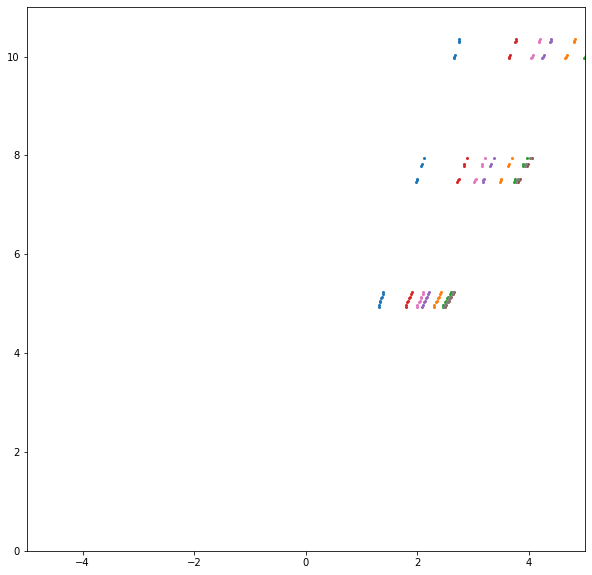

In [4]:
import matplotlib.pyplot as plt

ax = plt.figure(figsize=(10,10))
idx = 4

#plot (z vs y))
for i in range(num_trks):
  plt.scatter(cords[idx,i,:,1],cords[idx,i,:,2], s=4.0)
  plt.xlim(-5.,5.)
  plt.ylim(0.,11.)

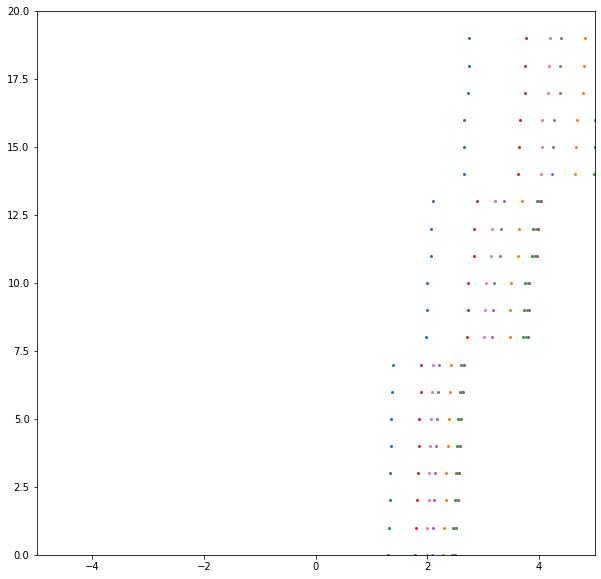

In [5]:
ax = plt.figure(figsize=(10,10))

#plot z vs id settore MDT
for i in range(num_trks):
  plt.scatter(cords[idx,i,:,1],cords[idx,i,:,3], s=4.0)
  plt.xlim(-5.,5.)
  plt.ylim(0.,20)

In [6]:
#simulazione impulso
#R[m] = p[GeV]/(0.3B(T)) = p / 1.2

#1 GeV: 1m
#5 GeV: 4.2m
#10 GeV: 8.3m
#20 GeV: 16.7m

#cords2 = cords.copy()

cords2 = np.zeros(shape=(cords.shape[0],cords.shape[1],cords.shape[2],cords.shape[3]) )

def d_vs_p(p, q, station):
     R = abs(p)/1.2
     h = abs(chambers[station]-chambers[0])
     if h<=R:
       sth = h/R
       cth = np.sqrt(1-sth*sth)
       d = R*(1.0-cth)*q
     else:
       d = 999999999.0
     return d

for i in range(cords.shape[0]):
  llp_p = np.random.uniform(1.0,20.0, size=cords.shape[1])
  labels[i,2] = np.sum(llp_p)
  p = llp_p
  sigmap = p*np.sqrt((0.25/p)**2 + (3.27e-2)**2 + (0.168*p*1e-3)**2)
  
  q = np.zeros(shape=cords.shape[1])
  qal = 2*np.random.randint(2, size=int(cords.shape[1]/2))-1
  
  for iq in range(len(qal)):
    q[iq] = qal[iq]
    q[iq+len(qal)] = -qal[iq]
  
  for j in range(cords.shape[1]):
    for k in range(cords.shape[2]):
      psm = np.random.normal(loc=p[j], scale=sigmap[j])
      d = d_vs_p(psm, q[j], k)
      cords2[i,j,k,1] = cords[i,j,k,1] + d
      cords2[i,j,k,0] = cords[i,j,k,0]
      cords2[i,j,k,2] = cords[i,j,k,2]
      cords2[i,j,k,3] = cords[i,j,k,3]
      #if k==19:
      #  print('psm,q[j],d,c,c2: ',psm,q[j],d,cords[i,j,k,1],cords2[i,j,k,1])


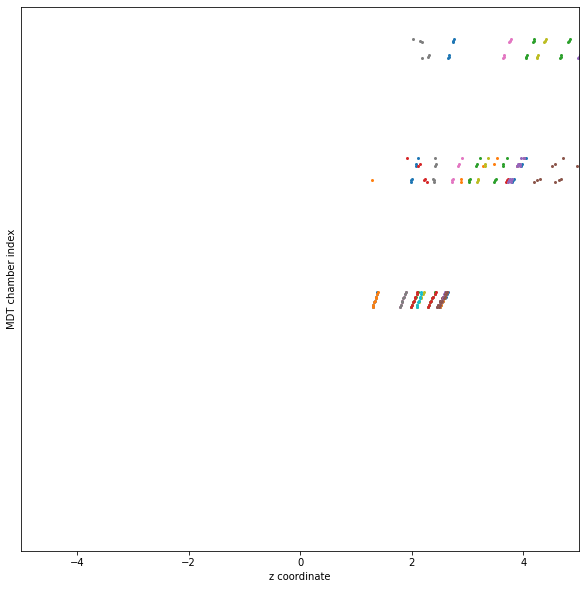

In [7]:
ax = plt.figure(figsize=(10,10))
for i in range(num_trks):
  plt.scatter(cords[idx,i,:,1],cords[idx,i,:,2], s=4.0)
  plt.scatter(cords2[idx,i,:,1],cords2[idx,i,:,2] , s=4.0)
  plt.xlabel('z coordinate')
  plt.ylabel('MDT chamber index')
  plt.yticks([])
  
  plt.xlim(-5.,5.)
  plt.ylim(0.,11.)

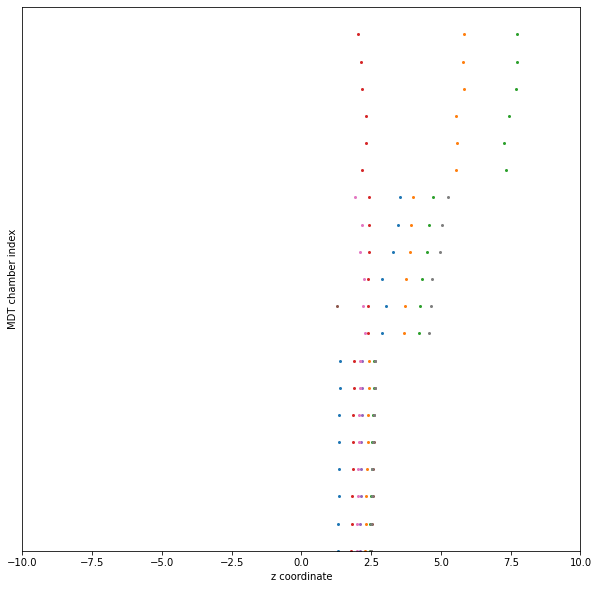

In [8]:
ax = plt.figure(figsize=(10,10))
for i in range(num_trks):
  plt.scatter(cords2[idx,i,:,1],cords2[idx,i,:,3], s=4.0)
  plt.xlabel('z coordinate')
  plt.ylabel('MDT chamber index')
  
  plt.yticks([])
  plt.xlim(-10.,10.)
  plt.ylim(0.,20.)

In [9]:
#make images
hist = np.empty(shape=(cords2.shape[0],cords2.shape[2], 333))
for eve in range(cords2.shape[0]):
  for i in range(cords2.shape[2]):
    h_tmp,_ = np.histogram(cords2[eve,:,i,1], bins=333, range=[-10., 10.])
    hist[eve,i,:] = h_tmp

Text(0, 0.5, 'MDT chamber index')

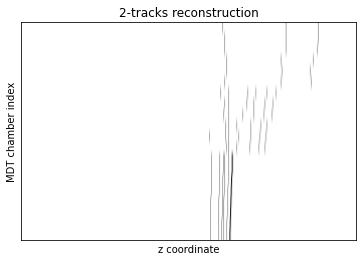

In [10]:
plt.imshow(hist[idx],aspect='auto', origin='lower', cmap=plt.cm.binary)
plt.xticks([])
plt.yticks([])
plt.title("2-tracks reconstruction")
plt.xlabel('z coordinate')
plt.ylabel('MDT chamber index')

In [11]:
#resolution and multiple hits
hist_reso = hist.copy()
for eve in range(hist_reso.shape[0]):
  for i in range(hist_reso.shape[1]):
    for j in range(hist_reso.shape[2]):
      if hist_reso[eve,i,j]<1.0:
        continue     
      random_hits = np.random.randint(3)
      random_sign = 2*np.random.randint(2)-1
      for k in range(random_hits):
        if random_sign>0:
          if j+k < hist_reso.shape[2]:
            hist_reso[eve,i,j+k] += 1.0
        else:
          if j-k >= 0:
            hist_reso[eve,i,j-k] += 1.0


Text(0, 0.5, 'MDT chamber index')

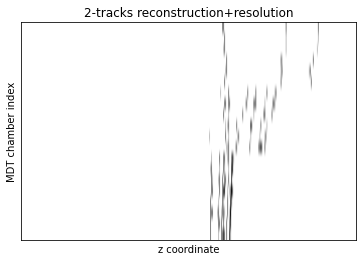

In [12]:
plt.imshow(hist_reso[idx],aspect='auto', origin='lower', cmap=plt.cm.binary)
plt.xticks([])
plt.yticks([])
plt.title("2-tracks reconstruction+resolution")
plt.xlabel('z coordinate')
plt.ylabel('MDT chamber index')

In [13]:
#noise
hist_noise = hist_reso.copy()
for eve in range(hist_noise.shape[0]):
  ns_hit = len(hist[eve,hist[eve]>0])
  nr_hit = len(hist_reso[eve,hist_reso[eve]>0])-ns_hit
  nb_hit = np.random.poisson(lam=3*ns_hit)
  nb_hit -= nr_hit
  for k in range(nb_hit):
    random_index1 = np.random.randint(0, hist_noise.shape[1])
    random_index2 = np.random.randint(0, hist_noise.shape[2])
    hist_noise[eve,random_index1,random_index2] += 1.0

Text(0, 0.5, 'MDT chamber index')

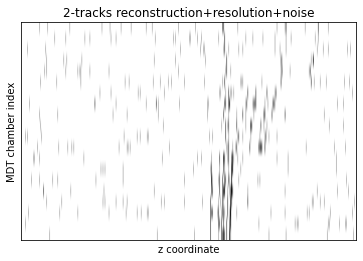

In [14]:
plt.imshow(hist_noise[idx],aspect='auto', origin='lower', cmap=plt.cm.binary)
plt.xticks([])
plt.yticks([])
plt.title("2-tracks reconstruction+resolution+noise")
plt.xlabel('z coordinate')
plt.ylabel('MDT chamber index')

In [15]:
print(hist.shape)
print(hist_reso.shape)
print(hist_noise.shape)
print(labels.shape)
print(cords.shape)
print(labels)   

(30000, 20, 333)
(30000, 20, 333)
(30000, 20, 333)
(30000, 3)
(30000, 8, 20, 4)
[[ 2.40367495e-02  1.93352778e-01  7.64769813e+01]
 [ 7.88996435e-02  1.24902804e-01  9.58736696e+01]
 [ 7.25161520e-02  2.42909253e-01  7.22801681e+01]
 ...
 [ 8.38497717e-02 -6.16158575e-02  6.47270136e+01]
 [ 9.21488006e-02 -2.13360710e-01  8.05086391e+01]
 [ 6.77167260e-02 -6.69278955e-03  7.91491833e+01]]


In [16]:
np.savez('MS_bkg_8_mod', labels, hist_noise, labels=labels, data_noise=hist_noise)